In [139]:
import momepy
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
%matplotlib inline

In [140]:
parcels = gpd.read_file('parcels_wdev2.shp')

In [141]:
parcels = parcels.reset_index()[['index', 'geometry']]
parcels = parcels.rename(columns={'index': 'ID'})

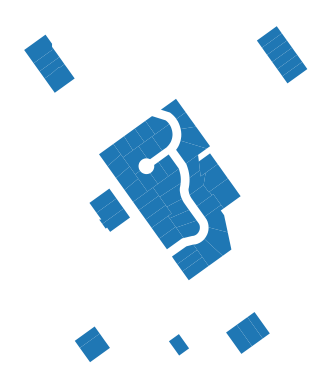

In [142]:
ax = parcels.plot()
ax.set_axis_off()

In [143]:
crs = parcels.estimate_utm_crs().to_epsg()
parcels = parcels.to_crs(crs)

In [144]:
def build_tessellation(df, unique_id, limit):
    limit = momepy.buffered_limit(df, buffer=limit)
    tessellation = momepy.Tessellation(df, unique_id=unique_id, limit=limit)
    tessellation_gdf = tessellation.tessellation
    tessellation_gdf = tessellation_gdf.reset_index(drop=True)
    tessellation_gdf['ID'] = tessellation_gdf.index

    return tessellation_gdf

In [145]:
tess = build_tessellation(parcels, 'ID', 1)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [146]:
def build_spatial_topology(df, contiguity, unique_id):
    if contiguity == 'rook':
        w = Rook.from_dataframe(df)
    elif contiguity == 'queen':
        w = Queen.from_dataframe(df)
    else:
        raise ValueError('Unknown contiguity type')

    # get component labels
    components = w.component_labels
    combined_polygons = df.dissolve(by=components)
    return combined_polygons, w

In [147]:
tess_rook, w_rook = build_spatial_topology(tess, 'rook', 'ID')

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There is 1 island with id: 0.
  warnings.warn(message)


In [148]:
#tess_rook.to_file('tess_rook.shp')

In [149]:
def get_distance(df, dist_band):
    for poly in range(len(df)):
        ID = df.iloc[poly].ID
        # Calcualtes distance for each point from each df. If Point resides along edge of df( within 1-meter), distance is is given NUll then dropped
        df[f'd_to_{ID}'] = (df.apply(lambda x: 
                                                df.iloc[poly].geometry.distance(x['geometry']) 
                                                if df.iloc[poly].geometry.distance(x['geometry']) < dist_band 
                                                else 0, axis=1)
                                                )
    
    return df

In [150]:
tess_rook = get_distance(tess_rook, dist_band=15.0)

In [151]:
tess_rook

,geometry,ID,d_to_0,d_to_1,d_to_4,d_to_10,d_to_12,d_to_20,d_to_43,d_to_54
0,"POLYGON ((481635.089 4399502.459, 481635.059 4...",0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",1,0.0,0.000000,12.955754,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",4,0.0,12.955754,0.000000,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",10,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((481527.294 4399737.959, 481531.733 4...",12,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",20,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",43,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",54,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [152]:
def identify_nearby_enclosures(df):
    cols = df.filter(regex='d_to_')
    df['nearby_enclosures'] = df[cols.columns.to_list()].sum(axis=1)
    return df

In [153]:
tess_rook = identify_nearby_enclosures(tess_rook)
tess_rook

,geometry,ID,d_to_0,d_to_1,d_to_4,d_to_10,d_to_12,d_to_20,d_to_43,d_to_54,nearby_enclosures
0,"POLYGON ((481635.089 4399502.459, 481635.059 4...",0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",1,0.0,0.000000,12.955754,0.0,0.0,0.0,0.0,0.0,12.955754
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",4,0.0,12.955754,0.000000,0.0,0.0,0.0,0.0,0.0,12.955754
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",10,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((481527.294 4399737.959, 481531.733 4...",12,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",20,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",43,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",54,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [154]:
def get_adj_id(x):
    ids = []
    x = dict(x.filter(regex='d_to_'))
    for col, row in x.items():
        if row != 0:
            ids.append(col.split('_')[-1]) 
    
    return ids


In [155]:
tess_rook['adjacent_ID'] = tess_rook.apply(lambda x: get_adj_id(x), axis=1)

In [156]:
tess_rook

,geometry,ID,d_to_0,d_to_1,d_to_4,d_to_10,d_to_12,d_to_20,d_to_43,d_to_54,nearby_enclosures,adjacent_ID
0,"POLYGON ((481635.089 4399502.459, 481635.059 4...",0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,[]
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",1,0.0,0.000000,12.955754,0.0,0.0,0.0,0.0,0.0,12.955754,[4]
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",4,0.0,12.955754,0.000000,0.0,0.0,0.0,0.0,0.0,12.955754,[1]
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",10,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,[]
4,"POLYGON ((481527.294 4399737.959, 481531.733 4...",12,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,[]
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",20,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,[]
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",43,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,[]
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",54,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,[]


In [157]:
df = tess_rook[tess_rook['nearby_enclosures'] != 0]

In [158]:
df['limit'] = df.apply(lambda x: x[f'd_to_{x.adjacent_ID[0]}'], axis=1)
df = df[['ID', 'limit', 'geometry']]

d:\mini-forge\envs\growth_model\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [159]:
remove_ids = df.ID.to_list()

In [160]:
tess2 = build_tessellation(df, 'ID', 12.955754)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...


Dissolving Voronoi polygons...


In [161]:
tess2.to_file('tess2.shp')

In [162]:
tess2

,ID,geometry
0,0,"POLYGON ((481595.707 4399665.268, 481597.415 4..."
1,1,"POLYGON ((481572.963 4399918.700, 481573.869 4..."


In [163]:
tess_rook = tess_rook[~tess_rook['ID'].isin(remove_ids)]
tess_rook = tess_rook[['ID', 'geometry']]

In [164]:
final_tess = pd.concat([tess_rook, tess2], ignore_index=True)

In [165]:
final_tess['ID'] = final_tess.index
final_tess

,ID,geometry
0,0,"POLYGON ((481635.089 4399502.459, 481635.059 4..."
1,1,"POLYGON ((481479.409 4399529.315, 481479.412 4..."
2,2,"POLYGON ((481527.294 4399737.959, 481531.733 4..."
3,3,"POLYGON ((481744.381 4399505.419, 481744.381 4..."
4,4,"POLYGON ((481423.468 4399990.705, 481427.908 4..."
5,5,"POLYGON ((481837.701 4399993.591, 481842.055 4..."
6,6,"POLYGON ((481595.707 4399665.268, 481597.415 4..."
7,7,"POLYGON ((481572.963 4399918.700, 481573.869 4..."


In [166]:
final_tess.to_file('final_tess.shp')

In [167]:
final_tess_rook, final_w_rook = build_spatial_topology(final_tess, 'rook', 'ID')

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 3, 4, 5.
  warnings.warn(message)


In [168]:
#final_tess_rook.to_file('final_tess_rook.shp')

In [170]:
parcels2join = parcels.sjoin(final_tess_rook, how='left', op='intersects')

d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [172]:
tess_merge = build_tessellation(parcels2join, 'ID_left', 16)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [174]:
tess_merge_ids = tess_merge.ID_left.to_list()

In [175]:
parcels = parcels[~parcels['ID'].isin(tess_merge_ids)]

In [176]:
final_parcels = pd.concat([parcels, tess_merge], ignore_index=True)
final_parcels

,ID,geometry,ID_left
0,0,"POLYGON ((481649.906 4399500.085, 481649.572 4...",25.0
1,1,"POLYGON ((481623.221 4399636.626, 481623.292 4...",10.0
2,2,"POLYGON ((481612.666 4399647.783, 481614.117 4...",9.0
3,3,"POLYGON ((481594.222 4399664.291, 481598.486 4...",29.0
4,4,"POLYGON ((481583.035 4399693.515, 481583.113 4...",22.0
5,5,"POLYGON ((481560.281 4399705.347, 481569.666 4...",23.0
6,6,"POLYGON ((481618.272 4399703.816, 481618.035 4...",49.0
7,7,"POLYGON ((481558.061 4399725.827, 481559.147 4...",17.0
8,8,"POLYGON ((481607.620 4399718.576, 481607.533 4...",47.0
9,9,"POLYGON ((481544.080 4399720.228, 481544.086 4...",18.0


In [177]:
final_parcels.to_file('final_parcels.shp')